In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import OrdinalEncoder

X_train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col='id')
X_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col='id')

lenc = OrdinalEncoder(categories = [['Insufficient_Weight','Normal_Weight', 'Overweight_Level_I','Overweight_Level_II','Obesity_Type_I','Obesity_Type_II', 'Obesity_Type_III']])
#lenc.fit(['Insufficient_Weight','Normal_Weight', 'Overweight_Level_I','Overweight_Level_II','Obesity_Type_I','Obesity_Type_II', 'Obesity_Type_III'])
y_train = X_train[['NObeyesdad']]
y_train['NObeyesdad'] = lenc.fit_transform(X_train[['NObeyesdad']])
X_train['NObeyesdad'] = y_train

In [4]:
X_train.shape

(20758, 17)

In [5]:
X_train

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,3.0
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,1.0
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,0.0
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,6.0
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,5.0
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,0.0
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,5.0


In [6]:
X_train.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

No missing values

In [7]:
X_train.select_dtypes(include=['category', 'object']).nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              3
MTRANS                            5
dtype: int64

In [8]:
for col in X_train.select_dtypes(include=['category', 'object']).columns:
    print(X_train[col].unique())

['Male' 'Female']
['yes' 'no']
['yes' 'no']
['Sometimes' 'Frequently' 'no' 'Always']
['no' 'yes']
['no' 'yes']
['Sometimes' 'no' 'Frequently']
['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']


There are not typos in labels

Let's define basic model for evaluation

In [9]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

def evaluate_data(data, target):
    model = XGBClassifier(n_estimators = 100, eval_metric = 'mlogloss', random_state=0)
    data = data.select_dtypes(exclude=['category','object'])
    return cross_val_score(model,data.loc[:,data.columns != 'NObeyesdad'], target, scoring='accuracy').mean()

def evaluate_outlier_removal(new_data,ref_data,ref_target):
    model = XGBClassifier(n_estimators = 100, eval_metric = 'mlogloss', random_state=0)
    kfold = KFold(5)
    
    new_data = new_data.select_dtypes(exclude=['category','object'])
    new_data = new_data.loc[:,new_data.columns != 'NObeyesdad']
    ref_data = ref_data.select_dtypes(exclude=['category','object'])
    ref_data = ref_data.loc[:,ref_data.columns != 'NObeyesdad']
    
    acc = 0
    
    for train_index, test_index in kfold.split(ref_data,ref_target):
        train_index = ref_data.iloc[train_index].index
        model.fit(new_data.loc[[x for x in train_index if x in new_data.index]], ref_target.loc[[x for x in train_index if x in new_data.index]])
        pred = model.predict(ref_data.iloc[test_index])
        acc += accuracy_score(pred, ref_target.iloc[test_index])
        
    return acc/5
    

def misclassified(data,target,model = None):
    if model is None:
        model = XGBClassifier(n_estimators = 100, eval_metric = 'mlogloss', random_state=0)
        kfold = KFold(5)

        data = data.select_dtypes(exclude=['category','object'])
        data = data.loc[:,data.columns != 'NObeyesdad']
        mc = []
        for train_index, test_index in kfold.split(data,target):
            model.fit(data.iloc[train_index], target[train_index])
            pred = model.predict(data.iloc[test_index])
            misclass = data.iloc[test_index]
            misclass['NObeyesdad'] = target[test_index]
            misclass['preds'] = pred
            mc.append(misclass[misclass['preds'] != target[test_index]])
            
        mc = pd.concat(mc)
    else:
        pred = model.predict(data)
        data['target'] = target
        data['preds'] = pred
        mc = data[data['target']!=data['preds']]
        data.drop(columns = ['target', 'preds'], inplace=True)
        
    return mc
        

In [10]:
evaluate_data(X_train, y_train)

0.8910299256998222

In [11]:
X_train.select_dtypes(exclude=['category', 'object']).skew()

Age           1.586252
Height        0.015803
Weight        0.093187
FCVC         -0.356611
NCP          -1.562253
CH2O         -0.212506
FAF           0.505726
TUE           0.670411
NObeyesdad   -0.143680
dtype: float64

Data is a bit skewed, let's experiment if we should try normalizig it

In [12]:
tmp = X_train.copy()
tmp['Age'] = np.log10(tmp['Age'])

In [13]:
evaluate_data(tmp, y_train)

0.8910299256998222

No impact

Let's add BMI column

In [14]:
X_train['BMI'] = X_train['Weight'] / X_train['Height']**2
X_test['BMI'] = X_test['Weight'] / X_test['Height']**2

In [15]:
'''evaluate_data(X_train, y_train)'''

'evaluate_data(X_train, y_train)'

Let's round height, weight and age

In [16]:
X_train = X_train.round({'Age':0, 'Height': 2, 'Weight':1})
X_test = X_test.round({'Age':0, 'Height': 2, 'Weight':1})

Interestingly enough it doesn't lead to better results, probably because BMI is pretty poor measure actually. If however BMI is small, it is hardly possible for someone to be obese, so we can consider such cases to be outliers and remove them. Similarly if BMI is high it is impossible to be underweight.

In [17]:
'''for i in range(8):
    idx = ~((X_train['BMI']>=(18.5+0.5*i)) & (X_train['NObeyesdad'] < 1))
    print(18.5+0.5*i,evaluate_outlier_removal(X_train[idx],X_train,y_train))'''

"for i in range(8):\n    idx = ~((X_train['BMI']>=(18.5+0.5*i)) & (X_train['NObeyesdad'] < 1))\n    print(18.5+0.5*i,evaluate_outlier_removal(X_train[idx],X_train,y_train))"

20.5 gives best results, so we remove those with BMI over 20.5 and classified as Underweight

In [18]:
idx = ~((X_train['BMI']>=(20.5)) & (X_train['NObeyesdad'] < 1))
X_train = X_train[idx]
y_train = y_train[idx]

In [19]:
for i in range(14):
    print(len(X_train[((X_train['BMI']<=18.5 + 0.5*i) & (X_train['NObeyesdad'] > 1))]))

16
19
21
23
27
36
50
62
90
111
145
192
327
504


In [20]:
'''for i in range(15):
    idx = ~((X_train['BMI']<=(19.5+0.1*i)) & (X_train['NObeyesdad'] > 1))
    print(19.5 + 0.1*i,evaluate_outlier_removal(X_train[idx],X_train,y_train))'''

"for i in range(15):\n    idx = ~((X_train['BMI']<=(19.5+0.1*i)) & (X_train['NObeyesdad'] > 1))\n    print(19.5 + 0.1*i,evaluate_outlier_removal(X_train[idx],X_train,y_train))"

Best result for 20.0. We romve those with BMI of 20 or less and classified as overweight

In [21]:
idx =  ~((X_train['BMI']<=(20)) & (X_train['NObeyesdad'] > 1))
X_train = X_train[idx]
y_train = y_train[idx]

In [22]:
evaluate_data(X_train, y_train)

0.8922332446165013

People with high weight and high BMI are a harder case, because BMI does not factor in bodyfat percentage and so muscular people are often misclassified. It is reasonable to assume however that if someone is two or more categories above what his BMI suggests, it is probably an outlier. 
Problem is however that classification does not follow BMI standard, so we need to approach differently.

In [23]:
 X_train.groupby('NObeyesdad')['BMI'].describe()

,count,mean,std,min,25%,50%,75%,max
NObeyesdad,,,,,,,,
0.0,2453.0,17.439496,1.000270,12.868541,16.979592,17.492242,17.944031,20.499483
1.0,3082.0,22.000999,2.194097,14.631670,20.568937,22.038567,23.661439,32.882414
2.0,2408.0,26.122946,1.620367,20.195092,25.390625,25.971309,26.672763,35.555556
3.0,2522.0,28.192491,1.835666,21.513859,27.080170,28.020083,29.086346,36.741456
4.0,2907.0,32.170332,2.466835,23.529412,31.020408,32.123438,33.298647,46.805188
5.0,3248.0,36.521958,2.112538,24.048460,35.436970,36.378753,38.023475,46.222483
6.0,4045.0,41.787580,2.645200,25.910684,40.372008,41.751829,43.615314,54.997991


In [24]:
X_train['BMI_target_bound'] = X_train.groupby('NObeyesdad')['BMI'].transform(lambda x: x.mean() - x.std())

People who have MBI much smaller than mean for category assigned

In [25]:
for i in range(11):
    print(3 + 0.5*i,len(X_train[(X_train['BMI_target_bound'] - X_train['BMI'] >= 3 + 0.5*i)]))

3.0 315
3.5 218
4.0 152
4.5 95
5.0 60
5.5 38
6.0 32
6.5 23
7.0 15
7.5 10
8.0 7


In [26]:
'''for i in range(10):
    idx = ~(X_train['BMI_target_bound'] - X_train['BMI'] >= 7.5 + 0.1*i)
    tmp = X_train.drop(columns='BMI_target_bound')
    print(7.5 + 0.1*i,evaluate_outlier_removal(tmp[idx],tmp,y_train))'''

"for i in range(10):\n    idx = ~(X_train['BMI_target_bound'] - X_train['BMI'] >= 7.5 + 0.1*i)\n    tmp = X_train.drop(columns='BMI_target_bound')\n    print(7.5 + 0.1*i,evaluate_outlier_removal(tmp[idx],tmp,y_train))"

8 gives best result. We remove entries with this difference

In [27]:
idx =  ~(X_train['BMI_target_bound'] - X_train['BMI'] >= 8)
X_train = X_train[idx]
X_train = X_train.drop(columns='BMI_target_bound')
y_train = y_train[idx]

In [28]:
evaluate_data(X_train, y_train)

0.8936489105699288

People who have MBI much bigger than mean for category assigned

In [29]:
X_train['BMI_target_bound'] = X_train.groupby('NObeyesdad')['BMI'].transform(lambda x: x.mean() + x.std())

In [30]:
for i in range(11):
    print(4 + 0.5*i,len(X_train[(X_train['BMI'] - X_train['BMI_target_bound'] >= 4 + 0.5*i) & (X_train['BMI'] <= 48)]))

4.0 141
4.5 105
5.0 79
5.5 50
6.0 33
6.5 23
7.0 14
7.5 9
8.0 6
8.5 6
9.0 4


In [31]:
'''for i in range(10):
    idx = ~(X_train['BMI'] - X_train['BMI_target_bound'] >= 6 + 0.1*i) & (X_train['BMI'] <= 48)
    tmp = X_train.drop(columns='BMI_target_bound')
    print(6 + 0.1*i,evaluate_outlier_removal(tmp[idx],tmp,y_train))'''

"for i in range(10):\n    idx = ~(X_train['BMI'] - X_train['BMI_target_bound'] >= 6 + 0.1*i) & (X_train['BMI'] <= 48)\n    tmp = X_train.drop(columns='BMI_target_bound')\n    print(6 + 0.1*i,evaluate_outlier_removal(tmp[idx],tmp,y_train))"

6.5 gives best result

In [32]:
idx =  ~(X_train['BMI'] - X_train['BMI_target_bound'] >= 6.5) & (X_train['BMI'] <= 48)
X_train = X_train[idx]
X_train = X_train.drop(columns='BMI_target_bound')
y_train = y_train[idx]

In [33]:
evaluate_data(X_train, y_train)

0.8936876265915892

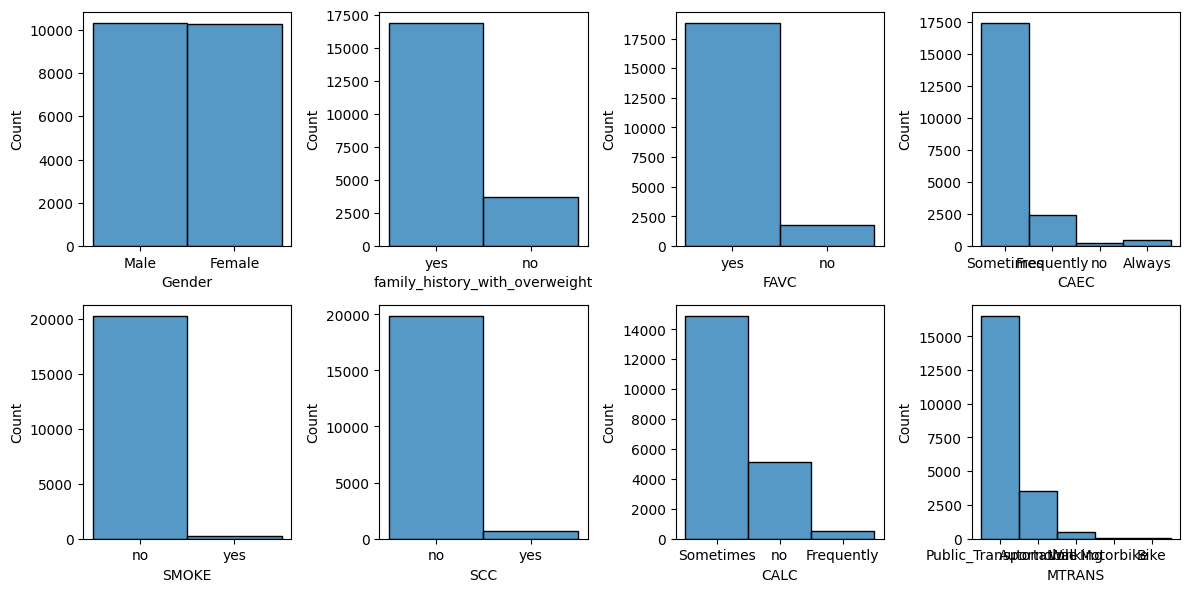

In [34]:
fig, ax = plt.subplots(2,4,figsize=(12,6))
ax = ax.flatten()
cols = X_train.select_dtypes(include=['object','category']).columns

for i in range(8):
    sns.histplot(data=X_train, x = cols[i], ax=ax[i])
    
fig.tight_layout()

<Axes: xlabel='Weight', ylabel='Height'>

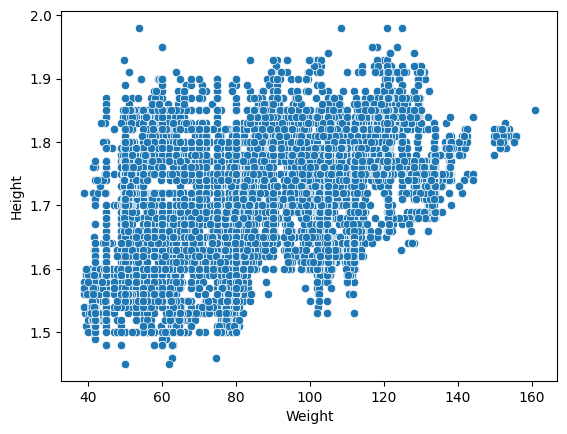

In [35]:
sns.scatterplot(data=X_train[X_train['NObeyesdad'] < 7], x='Weight', y='Height')

In [36]:
from sklearn.preprocessing import OneHotEncoder

cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']
enc = OneHotEncoder(sparse_output = False).set_output(transform='pandas')
enc.fit(X_train[cols])
X_train = pd.concat([X_train, enc.transform(X_train[cols])], axis=1)
X_test = pd.concat([X_test, enc.transform(X_test[cols])], axis=1)

to_drop = ['Gender_Female','family_history_with_overweight_no','FAVC_no','SMOKE_no','SCC_no']
X_train = X_train.drop(columns = to_drop)
X_test = X_test.drop(columns = to_drop)

In [37]:
evaluate_data(X_train, y_train)

0.9040468510682178

In [38]:
enc = OrdinalEncoder(categories = [['no', 'Sometimes', 'Frequently', 'Always'],['no', 'Sometimes', 'Frequently', 'Always']]).set_output(transform='pandas')
cols = ['CAEC', 'CALC']
X_train = pd.concat([X_train, enc.fit_transform(X_train[cols])], axis=1)
X_test = pd.concat([X_test, enc.transform(X_test[cols])], axis=1)

In [39]:
evaluate_data(X_train, y_train)

0.9084237271780375

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform='pandas')
train_add = scaler.fit_transform(X_train[['Age','Weight','BMI']])
test_add = scaler.transform(X_test[['Age','Weight','BMI']])

X_train[['Age','Weight','BMI']] = train_add
X_test[['Age','Weight','BMI']] = test_add

In [41]:
evaluate_data(X_train, y_train)

0.9084237271780375

In [42]:
X_train = X_train.select_dtypes(include=['int64','float64'])
X_test = X_test.select_dtypes(include=['int64','float64'])
X_train = X_train.drop(columns = 'NObeyesdad')

In [43]:
from lightgbm import LGBMClassifier
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',100,1000)
    learning_rate = trial.suggest_float('learning_rate',0.01,1)
    min_child_weight = trial.suggest_float('min_child_weight',0.1,50)
    max_depth = trial.suggest_int('max_depth',3,10)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.7,1)
    subsample = trial.suggest_float('subsample',0.5,1)
    reg_lambda = trial.suggest_float('reg_lambda', 0.001, 10, log = True)
    reg_alpha = trial.suggest_float('reg_alpha', 0.001, 10, log = True)
    num_leaves = 2 ** max_depth
    
    model = LGBMClassifier(n_estimators = n_estimators, learning_rate = learning_rate, min_child_weight = min_child_weight,
                        max_depth = max_depth, colsample_bytree = colsample_bytree, subsample = subsample, reg_lambda = reg_lambda,
                           reg_alpha = reg_alpha, num_leaves = num_leaves, metric = 'multi_logloss', verbose = -1)
    return cross_val_score(model,X_train, y_train, scoring='accuracy').mean()
    

In [44]:
'''study = optuna.create_study(study_name = 'study1', direction = 'maximize')'''

"study = optuna.create_study(study_name = 'study1', direction = 'maximize')"

In [45]:
'''study.optimize(objective, n_trials = 50)'''

'study.optimize(objective, n_trials = 50)'

In [46]:
'''study.best_value, study.best_params'''

'study.best_value, study.best_params'

Best for LGBM: 0.91265478349468 {'n_estimators': 551, 'learning_rate': 0.08049852985271347, 'min_child_weight': 12.36001667250277, 'max_depth': 3, 'colsample_bytree': 0.8346441158620809, 'subsample': 0.8574803271255999, 'reg_lambda': 1.6359555481485917, 'reg_alpha': 0.5095976371725309}

(0.9122656902617778,
 {'n_estimators': 183,
  'learning_rate': 0.2140988904706678,
  'min_child_weight': 7.180522548077616,
  'max_depth': 7,
  'colsample_bytree': 0.7000396068947157,
  'sample': 0.8089390706821744,
  'gamma': 0.5109276485597596})

In [47]:
parameters = {'n_estimators': 551, 'learning_rate': 0.08049852985271347, 'min_child_weight': 12.36001667250277, 'max_depth': 3, 'colsample_bytree': 0.8346441158620809, 'subsample': 0.8574803271255999, 'reg_lambda': 1.6359555481485917, 'reg_alpha': 0.5095976371725309}
parameters['num_leaves'] = 8
parameters['verbose'] = -1
parameters['metric'] = 'multi_logloss'
model = LGBMClassifier(**parameters)
'''model = XGBClassifier(n_estimators = 183, learning_rate = 0.2140988904706678, min_child_weight = 7.180522548077616,
                        max_depth = 7, colsample_bytree = 0.7000396068947157, sample = 0.8089390706821744, gamma = 0.5109276485597596, eval_metric = 'mlogloss')'''
model.fit(X_train,y_train)

LGBMClassifier(colsample_bytree=0.8346441158620809,
               learning_rate=0.08049852985271347, max_depth=3,
               metric='multi_logloss', min_child_weight=12.36001667250277,
               n_estimators=551, num_leaves=8, reg_alpha=0.5095976371725309,
               reg_lambda=1.6359555481485917, subsample=0.8574803271255999,
               verbose=-1)

In [48]:
preds = model.predict(X_test)
X_test['NObeyesdad'] = preds
ews = X_test[['NObeyesdad']]

In [49]:
ews[['NObeyesdad']] = lenc.inverse_transform(ews[['NObeyesdad']])
ews.reset_index().to_csv('submission.csv', index=False)

In [50]:
'''miscls = misclassified(X_train,y_train,model)'''

'miscls = misclassified(X_train,y_train,model)'

In [51]:
'''miscls.describe()'''

'miscls.describe()'

In [52]:
'''X_train.describe()'''

'X_train.describe()'

In [53]:
'''X_train_enriched = pd.concat([X_train,miscls.iloc[:,:-2]],ignore_index=True)
y_train_enriched = pd.concat([y_train['NObeyesdad'],miscls['target']], axis=0, ignore_index=True).to_frame(name='NObeyesdad')'''

"X_train_enriched = pd.concat([X_train,miscls.iloc[:,:-2]],ignore_index=True)\ny_train_enriched = pd.concat([y_train['NObeyesdad'],miscls['target']], axis=0, ignore_index=True).to_frame(name='NObeyesdad')"

In [54]:
'''model2 = XGBClassifier(n_estimators = 183, learning_rate = 0.2140988904706678, min_child_weight = 7.180522548077616,
                        max_depth = 7, colsample_bytree = 0.7000396068947157, sample = 0.8089390706821744, gamma = 0.5109276485597596, eval_metric = 'mlogloss')
model2.fit(X_train_enriched,y_train_enriched)'''

"model2 = XGBClassifier(n_estimators = 183, learning_rate = 0.2140988904706678, min_child_weight = 7.180522548077616,\n                        max_depth = 7, colsample_bytree = 0.7000396068947157, sample = 0.8089390706821744, gamma = 0.5109276485597596, eval_metric = 'mlogloss')\nmodel2.fit(X_train_enriched,y_train_enriched)"

In [55]:
'''miscls1 = misclassified(X_train_enriched,y_train_enriched,model)
miscls2 = misclassified(X_train_enriched,y_train_enriched,model2)'''

'miscls1 = misclassified(X_train_enriched,y_train_enriched,model)\nmiscls2 = misclassified(X_train_enriched,y_train_enriched,model2)'

In [56]:
'''preds = model2.predict(X_test)
X_test['NObeyesdad'] = preds
ews = X_test[['NObeyesdad']]

ews[['NObeyesdad']] = lenc.inverse_transform(ews[['NObeyesdad']])
ews.reset_index().to_csv('submission.csv', index=False)'''

"preds = model2.predict(X_test)\nX_test['NObeyesdad'] = preds\news = X_test[['NObeyesdad']]\n\news[['NObeyesdad']] = lenc.inverse_transform(ews[['NObeyesdad']])\news.reset_index().to_csv('submission.csv', index=False)"